In [1]:
#import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
#read data
xy=sio.loadmat('./SimulatedDataWithTTF.mat')
x=xy['SimulateData']
#convert images to 1d array to feed simple RNN
image_stream=np.zeros([np.size(x,axis=0),np.size(x,axis=1),x[1,1].size])
for i in range(np.size(x,axis=0)):
    for j in range(np.size(x,axis=1)):
        image_stream[i,j,:]=np.reshape(x[i,j],(x[1,1].size,))
train_size=int(np.size(image_stream,axis=0)*0.8)
train_set_input=image_stream[:train_size,:,:]
test_set_input=image_stream[train_size:,:,:]

TTF=xy['TTF1']
TTF=np.squeeze(TTF)
TTF_train=np.zeros([np.size(train_set_input,axis=0),np.size(train_set_input,axis=1)])
TTF_test=np.zeros([np.size(test_set_input,axis=0),np.size(test_set_input,axis=1)])
for i in range(np.size(train_set_input,axis=0)):
    image_stream_len=int(TTF[i]*0.01)
    train_set_input[i,image_stream_len:,:]=0
    TTF_train[i,:image_stream_len]=np.fliplr([np.arange(TTF[i]-int(TTF[i]*0.01)*100,TTF[i],100)])

for i in range(np.size(test_set_input,axis=0)):
    image_stream_len=int(TTF[i+train_size]*0.01)
    test_set_input[i,image_stream_len:,:]=0
    TTF_test[i,:image_stream_len]=np.fliplr([np.arange(TTF[i+train_size]-int(TTF[i+train_size]*0.01)*100,TTF[i+train_size],100)])

TTF_train=TTF_train/8000.0
TTF_test=TTF_test/8000.0

In [3]:
timestep=np.size(train_set_input,axis=1)
input_dim=np.size(train_set_input,axis=2)
num_units=10
batch_size=4
initial_prediction_time=10



In [9]:
#mean absolute percentage error for performance evaluation
def mean_absolute_percentage_error(true_val,predicted_val):
    count=np.zeros([np.size(true_val,axis=2),1])
    percentage_error=np.zeros([np.size(true_val,axis=2),1])
    for i in range(np.size(true_val,axis=0)):
        for j in range(np.size(true_val,axis=1)):
            for k in range(initial_prediction_time,np.size(true_val,axis=2)):
                if(true_val[i,j,k]!=0.0):
                    percentage_error[k]+=(np.abs((true_val[i,j,k]-predicted_val[i,j,k])/true_val[i,j,k]))
                    count[k]+=1
    for i in range(np.size(true_val,axis=2)):
        if count[i]==0:
            percentage_error[i]=0
        else:
            percentage_error[i]=percentage_error[i]/count[i]
    
    return percentage_error

In [5]:
#Inputs & Outputs => Data
encoder_input=tf.placeholder(tf.float32,[batch_size,timestep,input_dim])#input placeholder
ground_truth=tf.placeholder(tf.float32,[batch_size,timestep])#true output placeholder
#Build encoder part
encoder_cell=tf.nn.rnn_cell.BasicLSTMCell(num_units,name='encoder',dtype=tf.float32)#LSTM cell
initial_state = encoder_cell.zero_state(batch_size, dtype=tf.float32)
encoder_outputs,encoder_state=tf.nn.dynamic_rnn(encoder_cell,encoder_input,
                                                initial_state=initial_state)#Run dynamic RNN
W2=tf.Variable(np.random.rand(num_units,timestep),dtype=tf.float32)
b2=tf.Variable(np.random.rand(1,1),dtype=tf.float32)
#output vector (It is called as vector because outputs are created as vectors of size timestep)
W2=tf.Variable(np.random.rand(num_units,1),dtype=tf.float32)
b2=tf.Variable(np.random.rand(1,1),dtype=tf.float32)
predictions=[tf.matmul(tf.squeeze(encoder_outputs[i,:,:]),W2)+b2 for i in range(encoder_outputs.get_shape().as_list()[0])]
predictions=tf.stack(predictions)

In [6]:
ground_truth=tf.expand_dims(ground_truth,axis=2)
mask=tf.sign(tf.abs(ground_truth[:,initial_prediction_time:,:]))
error=tf.reduce_sum(((ground_truth[:,initial_prediction_time:,:]-predictions[:,initial_prediction_time:,:])**2)*mask)#error

train_step=tf.train.AdamOptimizer(0.001).minimize(error)#optimizer (applies 1 step training)- 
                                                        #AdaGrad is preferred for its convergence rate

0
Train: 200 2.713643079847097 63.40473
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[197.]
[193.]
[190.]
[186.]
[181.]
[179.]
[173.]
[171.]
[169.]
[166.]
[161.]
[155.]
[152.]
[142.]
[137.]
[128.]
[124.]
[119.]
[114.]
[109.]
[104.]
[99.]
[95.]
[90.]
[84.]
[78.]
[72.]
[64.]
[58.]
[55.]
[49.]
[45.]
[40.]
[33.]
[30.]
[26.]
[19.]
[9.]
[5.]
[0.]


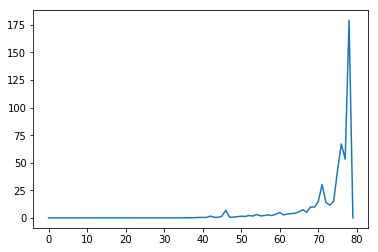

1
Train: 200 1.2449412854015827 4.101796
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[200.]
[197.]
[193.]
[190.]
[186.]
[181.]
[179.]
[173.]
[171.]
[169.]
[166.]
[161.]
[155.]
[152.]
[142.]
[137.]
[128.]
[124.]
[119.]
[114.]
[109.]
[104.]
[99.]
[95.]
[90.]
[84.]
[78.]
[72.]
[64.]
[58.]
[55.]
[49.]
[45.]
[40.]
[33.]
[30.]
[26.]
[19.]
[9.]
[5.]
[0.]


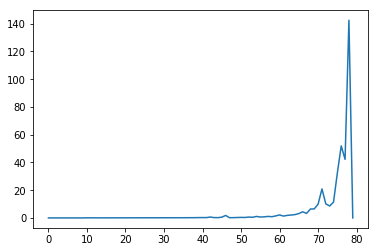

2


KeyboardInterrupt: 

In [10]:
with tf.Session() as sess:
    epoch_num=200
    for i in range(1):
        sess.run(tf.global_variables_initializer())#initialize variables
        data_length=int(len(TTF_train)/batch_size)
        for epoch in range(epoch_num):
            sum_error=0.0
            max_error=0.0
            count_sum=0.0
            print(epoch)
            for frame_id in range(data_length):
                batch_in=train_set_input[frame_id*batch_size:(frame_id+1)*batch_size,:,:]
                batch_out=TTF_train[frame_id*batch_size:(frame_id+1)*batch_size,:]
                [_error,_train_step,_predictions]=sess.run(
                        [error,train_step,predictions],
                        feed_dict={
                            encoder_input:batch_in,
                            ground_truth:np.expand_dims(batch_out,axis=2)
                        }
                    )
                sum_error+=_error
                max_error=max(_error,max_error)
                count_sum+=1
            print("Train:",epoch_num,sum_error/count_sum,max_error)
            #Test
            
            dummy_error=[]
            cum_batch_out=[]
            cum_predictions=[]
            for frame_id in range(int(np.size(TTF_test,axis=0)/batch_size)):
                batch_in=test_set_input[frame_id*batch_size:(frame_id+1)*batch_size,:,:]
                batch_out=TTF_test[frame_id*batch_size:(frame_id+1)*batch_size,:]
                [_error,_mask,_predictions]=sess.run(
                        [error,mask,predictions],
                        feed_dict={
                            encoder_input:batch_in,
                            ground_truth:np.expand_dims(batch_out,axis=2)
                        }
                    )
                cum_batch_out.append(batch_out)
                cum_predictions.append(_predictions)
            cum_predictions=np.squeeze(np.asarray(cum_predictions))
            cum_batch_out=np.asarray(cum_batch_out)
            mperror=mean_absolute_percentage_error(cum_batch_out,cum_predictions)
            plt.figure()
            plt.plot(mperror)
            plt.show()    

            

In [ ]:
mperror=mean_absolute_percentage_error(cum_batch_out,cum_predictions)
